In [1]:
!pip install neuralprophet prisma prophet

In [2]:
import pandas as pd
from neuralprophet import NeuralProphet
from prophet import Prophet
from matplotlib import pyplot as plt
import pickle
from prisma import Prisma
import asyncio
from datetime import datetime
import json


In [3]:
# prisma = Prisma()

# await prisma.connect()

# gte = datetime.strptime("2023-05-12T00:00:00+0300", '%Y-%m-%dT%H:%M:%S%z')
# lte = datetime.strptime("2023-05-13T23:59:59+0300", '%Y-%m-%dT%H:%M:%S%z')

# weather_records = await prisma.weatherrecord.find_many(
#     where={
#         # "createdAt": {
#         #     "gte": gte,
#         #     "lte": lte,
#         # },
#         'weatherStationId': "b92047e5-b481-4374-9fde-12eb295bf373"
#     },
#     order={
#         "createdAt": "asc"
#     }
# )
df = pd.read_csv('weather_records.csv')
df['createdAt'] = pd.to_datetime(df['createdAt']).dt.tz_localize(None)
# df['createdAt'] = df['createdAt'].apply(lambda x: x.strftime('%Y-%m-%d'))
# weather_records.csv

In [4]:
print(len(df))

1077323


In [5]:
df['weatherRecord'] = df['weatherRecord'].apply(lambda x: json.loads(x))


df.head()

,id,createdAt,weatherRecord,weatherStationId
0,1077353,2023-05-13 23:15:28.727,"{'humidityFromDTH22': 50, 'pressureFromBMP180'...",b92047e5-b481-4374-9fde-12eb295bf373
1,1077352,2023-05-13 23:15:27.709,"{'humidityFromDTH22': 50, 'pressureFromBMP180'...",b92047e5-b481-4374-9fde-12eb295bf373
2,1077351,2023-05-13 23:15:26.695,"{'humidityFromDTH22': 50.09999847, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
3,1077350,2023-05-13 23:15:25.683,"{'humidityFromDTH22': 50.09999847, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
4,1077349,2023-05-13 23:15:24.663,"{'humidityFromDTH22': 50.09999847, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373


In [6]:
df.dtypes
# df['weatherRecord'].apply(lambda x: x['humidityFromDTH22'])

id                           int64
createdAt           datetime64[ns]
weatherRecord               object
weatherStationId            object
dtype: object

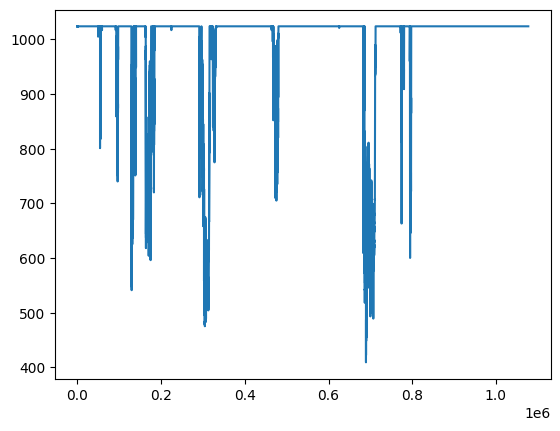

In [7]:
# df['weatherRecord'].apply(lambda x: x['analogSignalFromRainSensor'] if x['analogSignalFromRainSensor'] <= 1024 else None)
plt.plot(df['id'], df['weatherRecord'].apply(lambda x: x['analogSignalFromRainSensor'] if x['analogSignalFromRainSensor'] <= 1024 else None))
plt.show()

In [8]:
# data = pd.DataFrame({'ds': df['createdAt'], 'y': df['weatherRecord'].apply(lambda x: x['analogSignalFromRainSensor'] if x['analogSignalFromRainSensor'] <= 1024 else None) })
data = pd.DataFrame({'ds': df['createdAt'], 'y': df['weatherRecord'].apply(lambda x: x['temperatureFromBMP180'])})
data = data.drop_duplicates(subset=['ds'])






# Train modal

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 2019L corresponds to 2.756% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq S. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 256
WARNING - (py.warnings._showwarnmsg) - /Users/catdev/.pyenv/versions/3.9.16/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: U

Finding best initial lr:   0%|          | 0/300 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency -2019L corresponds to 2.756% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq S. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency -2019L corresponds to 2.756% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq S. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


Predicting: 4209it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


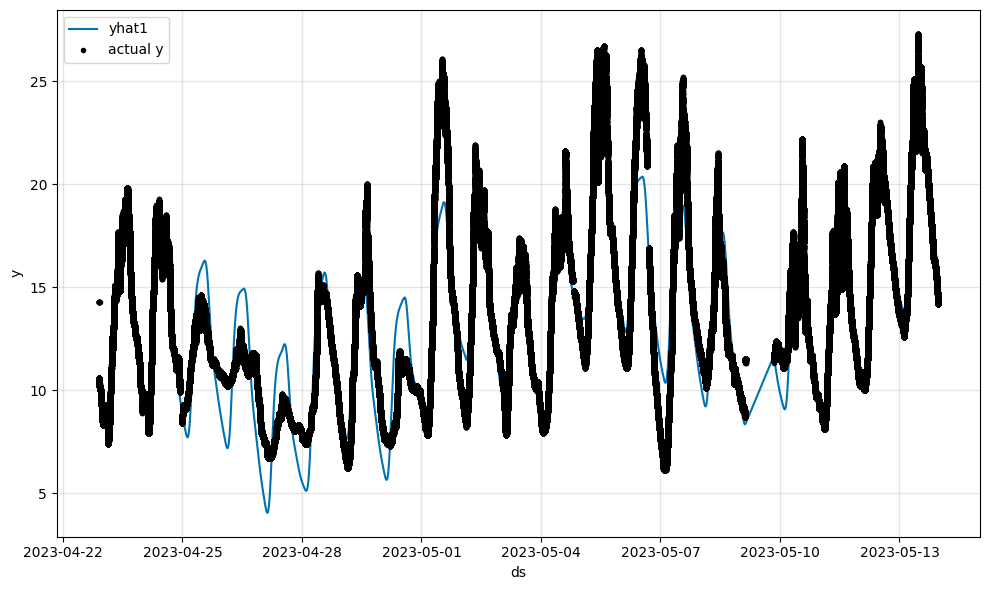

In [9]:

# m = NeuralProphet()
# m.fit(data, freq='S', epochs=30)

m = NeuralProphet(
    # Disable trend changepoints
    # n_changepoints=10,
    # Disable seasonality components
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    # Add the autogression
    # n_lags=10,
)

m.set_plotting_backend("matplotlib")  # Use matplotlib due to #1235
metrics = m.fit(data, freq='10T', epochs=5)


In [ ]:
future = m.make_future_dataframe(data, periods=500000)
# future['cap'] = 1024
# future['floor'] = 0
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency -2019L corresponds to 2.756% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq S. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - S


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


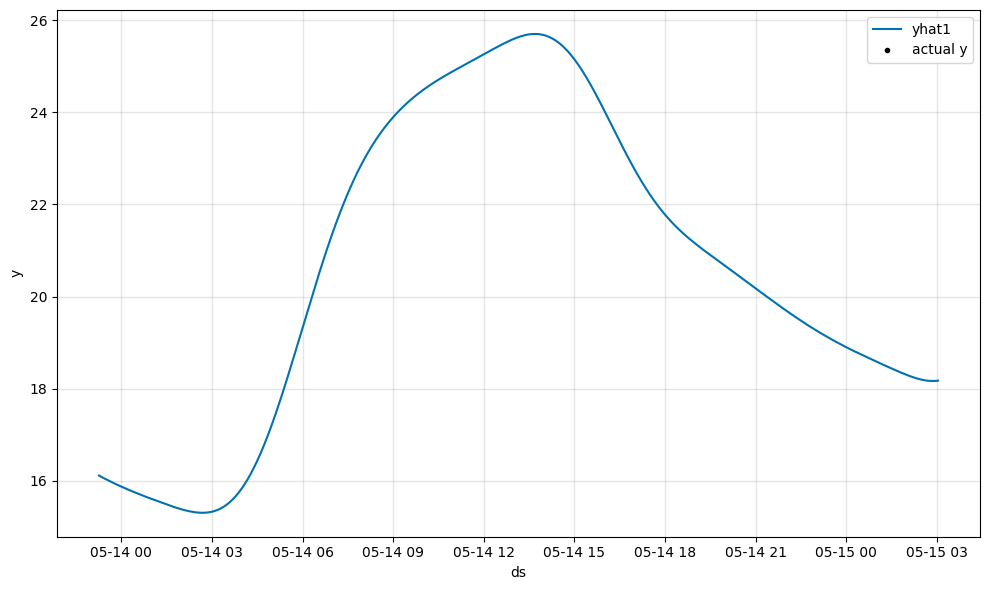

In [17]:
plot1 = m.plot(forecast)

In [ ]:
plot2 = m.plot_components(forecast)
plot2.show()

In [ ]:
with open('forecast_temperature_model.pkl', 'wb') as f:
    pickle.dump(m, f)

In [ ]:
print('done')